In [1]:
import os, shutil, sys
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import numpy.random as rand
import matplotlib.pyplot as mp
import keras
import keras.backend as K
import keras.preprocessing as kpre
import keras.datasets as kdat
import keras.models as kmod
import keras.layers as klay
import keras.optimizers as kopt
import keras.utils as kutil
import keras.callbacks as kcall
import keras.initializers as kinit
import keras.regularizers as kreg
import keras.applications as kapp
import sklearn.model_selection as slms
import tensorflow as tf
import pandas as pd
import multiprocessing
from tqdm import tnrange, tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from jupyterthemes import jtplot

Using TensorFlow backend.


In [2]:
# tf.enable_eager_execution()
jtplot.style()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

rand.seed(1000)
tf.set_random_seed(1000)

W0822 22:57:58.174498  2716 module_wrapper.py:136] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



In [3]:
width = 32
height = 32
batch_size = 10
nb_epochs = 500
code_length = 1024
use_gpu = True

In [4]:
(X_train, Y_train), (X_test, Y_test) = kdat.cifar10.load_data()

In [5]:
X_source = X_train[:50]
X_dest = X_source.copy()
rand.shuffle(X_dest)

In [6]:
def encoder(encoder_input):
    # Convolutional layer 1
    conv1 = tf.layers.conv2d(inputs=encoder_input,
                             filters=32,
                             kernel_size=(3, 3),
                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                             activation=tf.nn.tanh)

    # Convolutional output (flattened)
    conv_output = tf.contrib.layers.flatten(conv1)

    # Encoder Dense layer 1
    d_layer_1 = tf.layers.dense(inputs=conv_output,
                                units=1024,
                                activation=tf.nn.tanh)

    # Code layer
    code_layer = tf.layers.dense(inputs=d_layer_1,
                                 units=code_length,
                                 activation=tf.nn.tanh)

    return code_layer


def decoder(code_sequence, bs):
    # Decoder Dense layer 1
    d_layer_1 = tf.layers.dense(inputs=code_sequence,
                                units=1024,
                                activation=tf.nn.tanh)

    # Code output layer
    code_output = tf.layers.dense(inputs=d_layer_1,
                                  units=(height - 2) * (width - 2) * 3,
                                  activation=tf.nn.tanh)

    # Deconvolution input
    deconv_input = tf.reshape(code_output, (bs, height - 2, width - 2, 3))

    # Deconvolution layer 1
    deconv1 = tf.layers.conv2d_transpose(inputs=deconv_input,
                                         filters=3,
                                         kernel_size=(3, 3),
                                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                         activation=tf.sigmoid)

    # Output batch
    output_batch = tf.cast(tf.reshape(deconv1, (bs, height, width, 3)) * 255.0, tf.uint8)

    return deconv1, output_batch


def create_batch(t):
    X = np.zeros((batch_size, height, width, 3), dtype=np.float32)
    Y = np.zeros((batch_size, height, width, 3), dtype=np.float32)

    if t < X_source.shape[0] - batch_size:
        tmax = t + batch_size
    else:
        tmax = X_source.shape[0]

    for k, image in enumerate(X_source[t:tmax]):
        X[k, :, :, :] = image / 255.0

    for k, image in enumerate(X_dest[t:tmax]):
        Y[k, :, :, :] = image / 255.0

    return X, Y


graph = tf.Graph()


with graph.as_default():
    with tf.device('/cpu:0'):
        # Global step
        global_step = tf.Variable(0, trainable=False)

    with tf.device('/gpu:0' if use_gpu else '/cpu:0'):
        # Input batch
        input_images = tf.placeholder(tf.float32, shape=(None, height, width, 3))

        # Output batch
        output_images = tf.placeholder(tf.float32, shape=(None, height, width, 3))

        # Batch_size
        t_batch_size = tf.placeholder(tf.int32, shape=())

        # Encoder
        code_layer = encoder(encoder_input=input_images)

        # Decoder
        deconv_output, output_batch = decoder(code_sequence=code_layer,
                                              bs=t_batch_size)

        # Reconstruction L2 loss
        loss = tf.nn.l2_loss(output_images - deconv_output)

        # Training operations
        learning_rate = tf.train.exponential_decay(learning_rate=0.00025,
                                                   global_step=global_step,
                                                   decay_steps=int(X_source.shape[0] / (2 * batch_size)),
                                                   decay_rate=0.9,
                                                   staircase=True)

        trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)

        training_step = trainer.minimize(loss)
        
        
def predict(X, bs=1):
    feed_dict = {
        input_images: X.reshape((1, height, width, 3)) / 255.0,
        output_images: np.zeros((bs, height, width, 3), dtype=np.float32),
        t_batch_size: bs
    }

    return session.run([output_batch], feed_dict=feed_dict)[0]


def story(t):
    oimages = np.zeros(shape=(20, height, width, 3), dtype=np.uint8)
    oimages[0, :, :, :] = X_source[t]

    for i in range(1, 20):
        oimages[i, :, :, :] = predict(oimages[i - 1])

    fig, ax = mp.subplots(2, 10, figsize=(18, 4))

    for i in range(2):
        for j in range(10):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
            ax[i, j].imshow(oimages[(10 * i) + j])

    mp.show()

W0822 22:58:01.650210  2716 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0822 22:58:02.856258  2716 deprecation.py:323] From <ipython-input-6-6217aa2871e2>:7: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0822 22:58:02.859211  2716 deprecation.py:323] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\layers\convolutional.py:424: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__ca

In [7]:
if __name__ == '__main__':
    # Create a Tensorflow Session
    config = tf.ConfigProto(intra_op_parallelism_threads=multiprocessing.cpu_count(),
                            inter_op_parallelism_threads=multiprocessing.cpu_count(),
                            allow_soft_placement=True,
                            device_count={'CPU': 1,
                                          'GPU': 1 if use_gpu else 0})

    session = tf.InteractiveSession(graph=graph, config=config)

    # Initialize all variables
    tf.global_variables_initializer().run()

    # Train the model
    for e in range(nb_epochs):
        total_loss = 0.0

        for t in range(0, X_source.shape[0], batch_size):
            X, Y = create_batch(t)

            feed_dict = {
                input_images: X,
                output_images: Y,
                t_batch_size: batch_size
            }

            _, t_loss = session.run([training_step, loss], feed_dict=feed_dict)
            total_loss += t_loss

        print('Epoch {} - Loss: {}'.
              format(e + 1,
                     total_loss / float(X_train.shape[0])))

Epoch 1 - Loss: 0.1023436962890625
Epoch 2 - Loss: 0.09600498413085938
Epoch 3 - Loss: 0.09277770385742187
Epoch 4 - Loss: 0.08989453857421875
Epoch 5 - Loss: 0.08578148681640625
Epoch 6 - Loss: 0.07987414184570313
Epoch 7 - Loss: 0.0729347412109375
Epoch 8 - Loss: 0.06720297485351563
Epoch 9 - Loss: 0.06278922119140624
Epoch 10 - Loss: 0.05970243530273438
Epoch 11 - Loss: 0.07358667602539062
Epoch 12 - Loss: 0.06611653198242187
Epoch 13 - Loss: 0.06190438842773437
Epoch 14 - Loss: 0.05371115234375
Epoch 15 - Loss: 0.051207242431640626
Epoch 16 - Loss: 0.04792532470703125
Epoch 17 - Loss: 0.045110697631835936
Epoch 18 - Loss: 0.04261474243164062
Epoch 19 - Loss: 0.040542808837890625
Epoch 20 - Loss: 0.03837209167480469
Epoch 21 - Loss: 0.036576793212890625
Epoch 22 - Loss: 0.03481128356933594
Epoch 23 - Loss: 0.03328118957519531
Epoch 24 - Loss: 0.03186517761230469
Epoch 25 - Loss: 0.030620707397460936
Epoch 26 - Loss: 0.029772291259765625
Epoch 27 - Loss: 0.02888868896484375
Epoch 28 

Epoch 214 - Loss: 0.003857504539489746
Epoch 215 - Loss: 0.003835147819519043
Epoch 216 - Loss: 0.003812442817687988
Epoch 217 - Loss: 0.0037969778442382813
Epoch 218 - Loss: 0.0037913719940185545
Epoch 219 - Loss: 0.0037997149658203127
Epoch 220 - Loss: 0.0038196087646484374
Epoch 221 - Loss: 0.0038395940017700195
Epoch 222 - Loss: 0.0038467610931396485
Epoch 223 - Loss: 0.0038456302642822264
Epoch 224 - Loss: 0.003818340606689453
Epoch 225 - Loss: 0.003800731887817383
Epoch 226 - Loss: 0.003776706314086914
Epoch 227 - Loss: 0.0037579731369018553
Epoch 228 - Loss: 0.0037589553070068358
Epoch 229 - Loss: 0.00373898681640625
Epoch 230 - Loss: 0.003756906509399414
Epoch 231 - Loss: 0.003751545181274414
Epoch 232 - Loss: 0.003769670524597168
Epoch 233 - Loss: 0.0037495023345947265
Epoch 234 - Loss: 0.0037443382263183593
Epoch 235 - Loss: 0.00370131290435791
Epoch 236 - Loss: 0.0036694475555419923
Epoch 237 - Loss: 0.0036123765563964845
Epoch 238 - Loss: 0.0035637012481689453
Epoch 239 - L

Epoch 421 - Loss: 0.002049888286590576
Epoch 422 - Loss: 0.002051779155731201
Epoch 423 - Loss: 0.0020440650367736816
Epoch 424 - Loss: 0.002042244644165039
Epoch 425 - Loss: 0.0020316764068603515
Epoch 426 - Loss: 0.0020244803428649902
Epoch 427 - Loss: 0.00202663667678833
Epoch 428 - Loss: 0.0020301896476745606
Epoch 429 - Loss: 0.002053480281829834
Epoch 430 - Loss: 0.002059218597412109
Epoch 431 - Loss: 0.002077677345275879
Epoch 432 - Loss: 0.002072149200439453
Epoch 433 - Loss: 0.002078481502532959
Epoch 434 - Loss: 0.0020751469802856447
Epoch 435 - Loss: 0.0020816397285461424
Epoch 436 - Loss: 0.002081747055053711
Epoch 437 - Loss: 0.0020834162521362306
Epoch 438 - Loss: 0.0020678280639648437
Epoch 439 - Loss: 0.002052741413116455
Epoch 440 - Loss: 0.0020229944610595705
Epoch 441 - Loss: 0.002007121276855469
Epoch 442 - Loss: 0.0019902974700927735
Epoch 443 - Loss: 0.001986830406188965
Epoch 444 - Loss: 0.001979083938598633
Epoch 445 - Loss: 0.0019768754959106445
Epoch 446 - Los

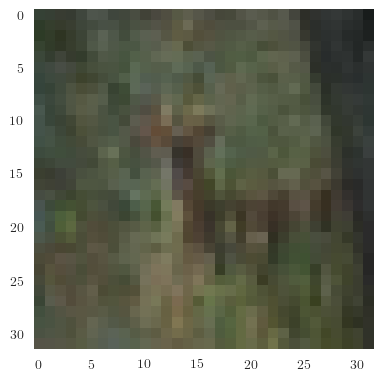

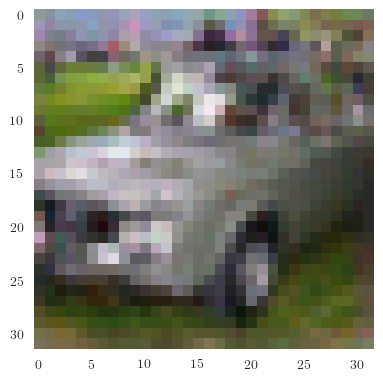

In [21]:
mp.imshow(X_source[10])
mp.grid(0)
mp.show()
mp.imshow(predict(X_source[10])[0])
mp.grid(0)
mp.show()

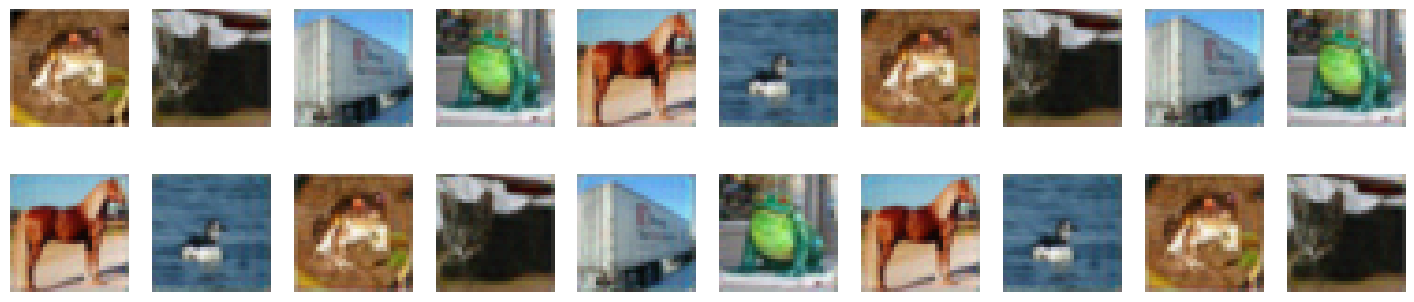

In [20]:
story(0)